#07 - 1 인공 신경망

###패션 MNIST
이 데이터셋은 10종류의 패션 아이템으로 구성되어있다.

패션 MNIST 데이터는 워낙 유명하기 때문에 많은 딥러닝 라이브러리에서 이 데이터를 가져올 수 있는 도구를 제공한다. 여기서는 텐서플로(TensorFlow)를 사용해 이 데이터를 불러오자.

다음 명렁으로 텐서플로의 케라스(Keras) 패키지를 임포트하고 패션MNIST 데이터를 다운로드한다.

In [ ]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) =\
   keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


keras.datasets.fashion_mnist 모듈 아래 load_data() 함수는 친절하게 훈련 데이터와 테스트 데이터를 나누어 반환한다. 이 데이터는 각각 입력과 타깃의 쌍으로 구성되어 있다.

전달받은 데이터의 크기를 확인해 보자.

In [ ]:
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


훈련 데이터는 60,000개의 이미지로 이루어져 있다. 각 이미지는 28 x 28 크기이다. 타깃도 60,000개의 원소가 있는 1차원 배열이다.

테스트 세트의 크기도 확인해보자.

In [ ]:
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


테스트 세트는 10,000개의 이미지로 이루어져 있다.

몇 개의 샘플을 그림으로 출력해보자.

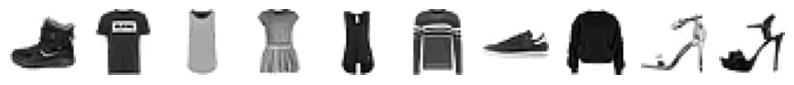

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
  axs[i].imshow(train_input[i],cmap='gray_r')
  axs[i].axis('off')
plt.show()

크기가 28 x 28이다 보니 꽤 작고 흐릿하다. 또 6장에서 다루었던 것처럼 반전된 흑백 이미지이다. 신발과 다양한 종류의 옷들이 보인다. 이 샘플들의 타깃값을 확인해보자.

파이썬의 리스트 내포를 사용해서 처음 10개 샘플의 타깃값을 리스트로 만든 후 출력하자.

In [ ]:
print([train_target[i] for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


패션 MNIST의 타깃은 0~9까지의 숫자 레이블로 구성된다. 각 숫자의 의미는 아직 모르지만 마지막 2개의 샘플이 같은 레이블(숫자 5)을 가지고 있다.

패션 MNIST에 포함된 10개 레이블의 의미는 다음과 같다.

|레이블||0||1||2||3||4||5||6||7||8||8|
|-||-||-||-||-||-||-||-||-||-||-|
|패션아이템||티셔츠||바지||스웨터||드레스||코트||샌달||셔츠||스니커즈||가방||앵클부츠|

이 값을 앞에서 출력한 결과와 비교해 보면 알 수 있다. 마지막으로 넘파이 unique() 함수로 레이블 당 샘플 개수를 확인해보자.

In [ ]:
import numpy as np
print(np.unique(train_target, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


0~9까지 레이블마다 정확히 6,000개의 샘플이 들어 있는 것을 볼 수 있다.

이 과정을 통해 패션 MNIST 데이터셋을 저장했고, 어떤 종류의 이미지로 이루어져 있는지 감을 잡았다.

###로지스틱 회귀로 패션 아이템 분류하기
이 훈련 샘플은 60,000개나 되기 때문에 전체 데이터를 한꺼번에 사용하여 모델을 훈련하는 것보다 샘플을 하나씩 꺼내서 모델을 훈련하는 방법이 더 효율적으로 보인다. 이런 상황에 잘 맞는 방법이 확률적 경사 하강법이다.

4장에서 SGDClassifier 클래스의 loss 매개변수를 'log_loss'로 지정하여 로지스틱 손실 함수를 최소화하는 확률적 경사 하강법 모델을 만들었다. 4장의 내용을 다시 되짚어 보면 SGDClassifier를 사용할 때 표준화 전처리된 데이터를 사용했다. 확률적 경사 하강법은 여러 특성 중 기울기가 가장 가파른 방향을 따라 이동한다. 만약 특성마다 값의 범위가 많이 다르면 올바르게 손실 함수의 경사를 내려 올 수 없다. 패션 MNIST의 경우 각 픽셀은 0 ~ 255 사이의 정숫값을 가진다. 이런 이미지의 경우 보통 255로 나누어 0 ~ 1 사이의 값으로 정규화한다. 이는 표준화는 아니지만 양수 값으로 이루어진 이미지를 전처리할 때 널리 사용하는 방법이다.

6장에서 했듯이 reshape() 메서드를 사용해 2차원 배열인 각 샘플을 1차원 배열로 펼치자. 4장에서 보았듯이 SGMClassifier는 2차원 입력을 다루지 못하기 때문에 각 샘플을 1차원 배열로 만들어야 한다.

In [ ]:
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

reshape() 메서드의 두 번째 매개변수를 28 x 28 이미지 크기에 맞게 지정하면 첫 번째 차원(샘플 개수)은 변하지 않고 원본 데이터의 두 번째, 세 번째 차원이 1차원으로 합쳐진다. 변환된 train_scaled의 크기를 확인해보자.

In [ ]:
print(train_scaled.shape)

(60000, 784)


4장에서처럼 SGDClassifier 클래스와 cross_validate 함수를 사용해 이 데이터에서 교차 검증올 성능을 확인해보자.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss='log', max_iter=5, random_state=42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1)
print(np.mean(scores['test_score']))

0.8196000000000001


여기에서는 SGDClassifier의 반복횟수(max_iter)를 5번으로 지정했다. 반복 횟수를 늘려도 성능이 크게 향상되지는 않는다.

###인공신경망

가장 기본적인 인공 신경망은 확률적 경사 하강법을 사용하는 로지스틱 회귀와 같다. 그렇다면 어떻게 인공 신경망으로 성능을 높일 수 있을까?

로지스틱 회귀에서와 비슷하게, 여기에서는 z_티셔츠, z_바지를 z1, z2와 같이  사용하도록 바꾸었다. z1~z10을 계산하고 이를 바탕으로 클래스를 예측하기 때문에 신경망의 최종 값을 만든다는 의미에서 출력층(output layer)라고 부른다.

인공 신경망에서는 z 값을 계산하는 단위를 뉴런(neuron)이라고 부른다. 하지만 뉴런에서 일어나는 계산은 선형 계산이 전부다. 이제는 뉴런이란 표현 대신에 유닛(unit)이라고 부른느 사람이 더 많아지고 있다.

그다음 픽셀1,픽셀2를 x1,x2와 같이 바꾸자. 784번째 픽셀에 해당하는 x784까지 나타냈다. 인공 신경망은 x1~x784까지를 입력층(input layer)라고 부른다. 즉 입력층은 픽셀값 자체이고 특별한 계산을 수행하지 않는다. 하지만 많은 사람이 입력층이라 부르기 때문에 관례를 따르자!

z1을 만들기 위해 픽셀1인 x1에 곱해지는 가중치는 w1,1 이라고 쓰고 z2를 만들기 위해 픽셀1인 x1에 곱해지는 가중치는 w1,2라고 쓴다. 절편은 뉴런마다 하나씩이므로 순서대로 b1,b2와 같이 나타내었다.

1장에서 소개했듯이 인공 신경망은 1943년 워런 매캘러와 월터 피츠가 제안한 뉴런 모델로 거슬러 올라간다. 이를 매컬러-피츠 뉴런이라고 부른다. 이런 인공 뉴런은 다음과 같은 생물학적 뉴런에서 영감을 얻어 만들어졌다.

생물학적 뉴런은 수상 돌기로부터 신호를 받아 세포체에 모은다. 신호가 어떤 입곗값에 도달하면 축삭 돌기를 통하여 다른 세포에 신호를 전달한다. 앞서 그렸던 인공 신경망의 출력층에 있는 인공 뉴런 하나와 비교하면 비슷하다.

하지만 생물학적 뉴런이 가중치(w1,1  , w2,1)와 입력을 곱하여 출력을 만드는 것은 아니다. 4장에서 보았던 시그모이드 함수나 소프트맥스 함수를 사용하는 것은 더욱 아니다. 인공 뉴런은 생물학적 뉴런의 모양을 본뜬 수학 모델이 불과하다. 생물학적 뉴런이 하는 일을 실제로 구현한 것이 아니다.

앞으로 계속 보겠지만 인공 신경망은 정말 우리의 뇌에 있는 뉴런과 같지 않다. 인공 신경망이란 말을 많이 사용할 수 밖에 없지만 정말 뇌 속에 있는 무언가를 만드는 일이 아니라는 것을 꼭 기억하자. 인공 신경망은 기존의 머신러닝 알고리즘이 잘 해결하지 못했던 문제에서 높은 성능을 발휘하는 새로운 종류의 머신러닝 알고리즘일 뿐이다. 여기에 대해서는 앞으로 배우면서 더 잘 이해할 수 있을 것이다.

그럼 확률적 경사 하강법을 사용한 로지스틱 회귀 모델이 가장 간단한 인공 신경망이라면 인공 신경망을 만들어도 성능이 좋아지지 않을 것 같다. 하지만 인공 신경망 모델을 만드는 최신 라이브러리들은 SGDClassifier에는 없는 몇 가지 기능을 제공한다. 이런 기능 덕택에 더 좋은 성능을 얻을 수 있다.

그럼 가장 인기가 높은 딥러닝 라이브러리인 텐서플로를 사용해 인공 신경망 모델을 만들어 보자.


###텐서플로와 케라스

텐서플로는 구글이 2015년 11월 오픈소스로 공개한 딥러닝 라이브러리이다. 이때를 기점으로 딥러닝에 대한 개발자의 관심이 늘어났고, 2016년 3월 알파고가 이세돌 9단을 이겨 대중에 알려지면ㅅ서 그야말로 폭발적으로 인기가 높아졌다.

텐서플로는 그 후 많은 발전을 거듭하면서 2019년 9월 2.0 버전이 릴리즈 되었다. 이 책에서는 텐서플로의 2.x 최신 버전을 사용한다.코랩에는 이미 텐서플로가 설치되어 있기 때문에 다음처럼 간단히 임포트하여 사용할 수 있다.

In [ ]:
import tensorflow as tf

텐서플로에는 저수준 API와 고수준 API가 있다. 바로 케라스(Keras)가 텐서플로의 고수준 API이다. 케라스는 2015년 3월 프랑소와 숄레가 만든 딥러닝 라이브러리이다.

딥러닝 라이브러리가 다른 머신러닝 라이브러리와 다른 점 중 하나는 그래픽 처리 장치인 GPU를 사용하여 인공 신경망을 훈련한다는 것이다. GPU는 벡터와 행렬 연산에 매우 최적화되어 있기 때문에 곱셈과 덧셈이 많이 수행되는 인공 신경망에 큰 도움이 된다.

케라스 라이브러리는 직접 GPU 연산을 수행하지 않는다. 대신 GPU 연산을 수행하는 다른 라이브러리를 백엔드(backend)로 사용한다. 예를 들면 텐서플로가 케라스의 백엔드 중 하나다. 이외에도 씨아노, CNTK와 같은 여러 딥러닝 라이브러리를 케라스 백엔드로 사용할 수 있다. 이런 케라스를 멀티-백엔드 케라스라고 부른다. 케라스 API만 익히면 다양한 딥러닝 라이브러리를 입맛대로 골라서 쓸 수 있는 셈이다. 이를 위해 케라스는 직관적이고 사용하기 편한 고수준 API를 제공한다.

프랑소와가 구글에 합류한 뒤 텐서플로 라이브러리에 케라스 API가 내장되었다.텐서플로 2.0부터는 케라스 API를 남기고 나머지 고수준 API를 모두 정리했고 케라스는 텐서플로의 핵심 API가 되었다. 다양한 백엔드를 지원했던 멀티-백엔드 케라스는 2.3.1 버전 이후로 더 이상 개발되지 않는다. 이제는 케라스와 텐서플로가 거의 동의어가 된 셈이다.

케라스는 아래와 같이 임포트한다.



In [ ]:
from tensorflow import keras

###인공 신경망으로 모델 만들기

여기에서는 앞서 로지스틱 회귀에서 만든 훈련 데이터 train_scaled와 train_target을 사용하자. 로지스틱 회귀에서는 교차 검증을 사용해 모델을 평가했지만, 인공 신경망에서는 교차 검증을 잘 사용하지 않고 검증 세트를 별도로 덜어내어 사용한다.

이렇게 하는 이유는

1. 딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증 점수가 안정적이고,
2. 교차 검증을 수행하기에는 훈련 시간이 너무 오래 걸리기 때문이다.

어떤 딥러닝 모델은 훈련하는 데 몇 시간, 심지어 며칠이 걸릴 수도 있다. 패션 MNIST 데이터 셋이 그만큼 크지는 않지만, 관례를 따라 검증 세트를 나누어 보자.

In [ ]:
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state=42)

훈련 세트에서 20%를 검증 세트로 덜어 내었다. 훈련 세트와 검증 세트의 크기를 알아보자.

In [ ]:
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [ ]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)


60,000개 중에 12,000개가 검증 세트로 분리되었다. 먼저 훈련 세트(train_scaled, train_target)로 모델을 만든다. 그다음 검증 세트(val_scaled, val_target)로 훈련한 모델을 평가해보자.

케라스의 레이어(keras.layer) 패키지 안에는 다양한 층이 준비되어 있다. 가장 기본이 되는 층은 밀집층(dense layer)이다. 왜 밀집이라고 부를까? 784개의 픽셀과 10개의 뉴런이 모두 연결된 선을 생각해보자. 784 x 10 = 7,840개의 연결된 선이 있다. 굉장히 빽빽하다. 그래서 밀집층이다.

이런 층을 양쪽의 뉴런이 모두 연결하고 있기 때문에 완전 연결층(fully connected layer)이라고도 부른다. 그럼 케라스의 Dense 클래스를 사용해 밀집층을 만들어보자. 필요한 매개변수는 뉴런 개수, 뉴런의 출력에 적용할 함수, 입력의 크기이다.



In [ ]:
dense = keras.layers.Dense(10, activation='softmax', input_shape=(784,))

첫 번째 매개변수로 뉴런 개수를 10개로 지정한다. 10개의 패션아이템을 분류하기 때문이다. 10개의 뉴런에서 출력되는 값을 확률로 바꾸기 위해서는 소프트맥스 함수를 사용한다. 4장에서 다중 분류에 왜 소프트맥스 함수를 사용하는지 자세히 설명했다. 케라스 층에서는 activation 매개변수에 이 함수를 지정하는데. 만약 2개의 클래스를 분류하는 이진 분류라면 시그모이드 함수를 사용하기 위해 activation ='sigmoid'와 같이 설정한다. 마지막으로는 세 번째 매개변수는 입력값의 크기이다. 10개의 뉴런이 각각 몇 개의 입력을 받는지 튜플로 지정한다. 여기에서는 784개의 픽셀 값을 받는다. 처음으로 신경망 층을 만들었다. 이제 이 밀집층을 가진 신경망 모델을 만들어야 한다. 케라스의 Sequential 클래스를 사용하자.

In [ ]:
model = keras.Sequential(dense)

Sequential 클래스의 객체를 만들 때 앞에서 만든 밀집층의 객체 dense를 전달했다. 여기서 만든 model 객체가 바로 신경망 모델이다.

소프트맥스와 같이 누런의 선형 방정식 계산 결과에 적용되는 함수를 활성화 함수(activation function)라고 부른다. 여기에서는 이 값을 a로 표시하겠다.

###인공 신경망으로 패션 아이템 분류하기

지금까지 사용했던 사이킷런에 비해 케라스에서 모델을 만드는 방식은 조금 다르다. 케라스 모델은 훈련하기 전에 설정 단계가 있다. 이런 설정을 model 객체의 compile() 메서드에서 수행한다. 꼭 지정해야 할 것은 손실 함수의 종류이다. 그다음 훈련 과정에서 계산하고 싶은 측정값을 지정한다.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

출력층은 10개의 뉴런이 있고, 10개의 클래스에 대한 확률을 출력한다. 첫 번째 뉴런은 티셔츠일 확률이고 두 번째 뉴런은 바지일 확률을 출력한다. 이진 분류와 달리 각 클래스에 대한 확률이 모두 출력되기 때문에 타깃에 해당하는 확률만 남겨 놓기 위해서 나머지 확률에는 모두 0을 곱한다.

예를 들어 샘플이 티셔츠일 경우 첫 번째 뉴런의 활성화 함수 출력인 a1에 크로스 엔트로피 손실 함수를 적용하고 나머지 활성화 함수 출력 a2~a10까지는 모두 0으로 만든다. 이렇게 하기 위해 티셔츠 샘플의 타깃값은 첫 번째 원소만 1이고 나머지는 모두 0인 배열로 만들 수 있다.

길이가 같은 넘파이 배열의 곱셈은 원소별 곱셈으로 수행된다. 결국 신경망은 티셔츠 샘플에서 손실을 낮추려면 첫 번째 뉴런의 활성화 출력 a1의 값을 가능한 1에 가깝게 만들어야 한다. 바로 이것이 크로스 엔트로피 손실 함수가 신경망에 원하는 바이다. 이와 같이 타깃값을 해당 클래스만 1이고 나머지는 모두 0인 배열로 만드는 것을 원-핫 인코딩(one-hot encoding)이라고 부른다.

따라서 다중 분류에서 크로스 엔트로피 손실 함수를 사용하려면 0, 1, 2와 같이 정수로 된 타깃값을 원-핫 인코딩으로 변환해야한다.

패션 MNIST 데이터의 타깃값을 확인해보자.

In [ ]:
print(train_target[:10])

[7 3 5 8 6 9 3 3 9 9]


모두 정수로 되어 있다. 하지만 텐서플로에서는 정수로 된 타깃값을 원-핫 인코등으로 바꾸지 않고 사용할 수 있더. 정수로된 타깃값을 사용해 크로스 엔트로피 손실을 계산하는 것이 바로 'sparse_categorical_crossentropy'이다. 빽빽한 배열 말고 정숫값 하나만 사용한다는 뜻에서 sparse(최소)라는 이름을 붙인 것 같다. 타깃값을 원-핫 인코딩으로 준비했다면 compile() 메서드에 손실 함수를 loss='categorical_crossentropy'로 지정한다. 이제 compile() 메서드의 두 번째 매개변수인 metrics에 대해 알아보자. 케라스는 모델이 훈련할 때 기본으로 에포크마다 손실 값을 출력해준다. 손실이 줄어드는 것을 보고 훈련이 잘 되었다는 것을 알 수 있지만 정확도를 함께 출력하면 더 좋을 것이다. 이를 위해 metrics 매개변수에 정확도 지표를 의미하는 'accuracy'를 지정해주었다.

자 이제 모델을 훈련해보자. 훈련한느 fit() 메서드는 사이킷런과 매우 비슷하다. 처음 두 매개변수에 입력(train_scaled)과 타깃(train_target)을 지정한다. 그다음 반복할 에포크 횟수를 epochs 매개변수로 지정한다. 사이킷런의 로지스틱 모델과 동일하게 5번 반복해 보자.

In [ ]:
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6097 - accuracy: 0.7910
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4752 - accuracy: 0.8385
Epoch 3/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4509 - accuracy: 0.8466
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4371 - accuracy: 0.8523
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4294 - accuracy: 0.8537


케라스는 친절하게 에포크마다 걸린 시간과 손실(loss), 정확도(accuracy)를 출력해 준다. 5번 반복에 정확도가 85%를 넘었다.  그럼 앞서 따로 떼어 놓은 검증 세트(val_scaled, val_target)에서 모델의 성능을 확인해보자. 케라스에서 모델의 성능을 평가하는 메서드는 evaluate() 메서드이다.

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.4374 - accuracy: 0.8522


[0.43744274973869324, 0.8521666526794434]

#07-2 심층 신경망




In [ ]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) =\
keras.datasets.fashion_mnist.load_data()

그다음 이미지의 픽셀값을 0 ~ 255 범위에서 0 ~ 1사이로 변환하고, 28 x 28 크기의 2차원 배열을 784 크기의 1차원 배열로 펼친다.마지막으로 사이킷런의 train_test_split() 함수로 훈련세트와 검증 세트로 나눈다.

In [ ]:
from sklearn.model_selection import train_test_split
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1,28*28)
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size = 0.2, random_state=42)

이제 인공 신경망 모델에 층을 2개 추가해보자. 입력층과 출력층 사이에 밀집층을 추가하자. 이렇게 입력층과 출력층 사이에 있는 모든 층을 은닉층(hidden layer)이라고 부른다.

은닉층에는 주황색 원으로 활성화 함수가 표시되어 있다. 활성화 함수는 신경망 층의 선형 방정식의 계산 값에 적용하는 함수다. 이전 절에서 출력층에 적용했던 소프트맥스 함수도 활성화 함수이다. 출력층에 적용하는 활성화 함수는 종류가 제한되어 있다. 이진 분류일 경우 시그모이드 함수를 사용하고 다중 분류일 경우 소프트맥스 함수를 사용한다. 이에 비해 은닉층의 활성화 함수는 비교적 자유롭다. 대표적으로 시그모이드 함수와 잠시후에 볼 렐루(ReLU) 함수 등을 사용한다.

그런데 은닉층에 왜 활성화 함수를 적용할까? 은닉층에서 선형적인 산술 계산만 수행한다면 수행 역할이 없는 셈이다. 선형 계산을 적당하게 비선형적으로 비틀어 주어야한다. 그래야 다음 층의 계산과 단순히 합쳐지지 않고 나름의 역할을 할 수 있다.

많이 사용하는 활성화 함수 중 하나는 4장에서 배웠던 시그모이드 함수이다. 이 함수는 뉴런의 출력과 z 값을 0과 1 사이로 압축한다. 그럼 시그모이드 활성화 함수를 사용한 은닉층과 소프트맥스 함수를 사용한 출력층을 케라스의 Dense 클래스로 만들어보자. 이전 절에서 언급했듯이 케라스에서 신경망의 첫 번째 층은 input_shape 매개변수로 입력의 크기를 꼭 지정해줘야 한다.

In [ ]:
dense1= keras.layers.Dense(100, activation='sigmoid', input_shape=(784,))
dense2 = keras.layers.Dense(10, activation= 'softmax')

dense1이 은닉층이고 100개의 누런을 가진 밀집층이다. 활성화 함수를 'sigmoid'로 지정했고 input_shape 매개변수에서 입력의 크기를 (784,)로 지정했다. 은닉층의 뉴런 개수를 정하는데는 특별한 기준이 없다. 맻 개의 뉴런을 두어야 할 지 판단하기 위해서는 상당한 경험이 필요하다.

여기에서 한 가지 제약 사항이 있다면 적어도 출력층의 뉴런보다는 많게 만드어야 한다. 클래스 10개에 대한 확률을 예측해야 하는데 이전 은닉층의 뉴런이 10개보다 적다면 부족한 정보가 전달 될것이다.

그다음 dense2는 출력층이다. 10개의 클래스를 분류하므로 10개의 뉴런을 두었고 활성화 함수는 소프트맥스 함수로 지정했다.

###심층 신경망 만들기

이제 앞에서 만든 dense1과 dense2 객체를 Sequential 클래스에 추가하여 심층 신경망(deep neural network,DNN)

In [ ]:
model = keras.Sequential([dense1, dense2])

Sequential 클래스의 객체를 만들 때 여러 개의 층을 추가하려면 이와 같이 dense1과 dense2를 리스트로 만들어 전달한다. 여기서 주의할 것은 출력층을 가장 마지막에 두어야 한다는 것이다. 이 리스트는 가장 처음 등장하는 은닉층에서 마지막 출력층의 순서로 나열해야 한다. 인공 신경망의 강력한 성능은 바로 이렇게 층을 추가하여 입력 데이터에 대해 연속적인 학습을 진행하는 능력에서 나온다. 이 책의 앞 장에서 배운 선형 회귀, 로지스틱 회귀, 결정 트리 등 다른 머신러닝 알고리즘들과 대조된다. 물론 2개 이상의 층을 추가할 수도 있다. 다음 장에서 더 복잡한 모델을 만들어 보자.

케라스는 모델의 summary() 메서드를 호출하면 층에 대한 유용한 정보를 얻을 수 있다.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


맨 첫 줄에 모델의 이름이 나온다. 그다음 이 모델에 들어 있는 층이 순서대로 나열됩니다. 이 순서는 맨 처음 추가한 은닉층에서 출력층의 순서대로 나열된다.

층마다 층 이름, 클래스, 출력 크기, 모델 파라미터 개수가 출력된다. 층을 만들 때 name 매개변수로 이름을 지정할 수 있다. 층 이름을 지정하지 않으면 케라스가 자동으로 'dense'라고 이름을 붙인다.

출력 크기를 보면 (None,100)이다. 첫 번째 차원은 샘플의 개수를 나타낸다. 샘플 개수가 아직 정의되어 있지 않기 때문에 None이다. 왜 일까? 케라스 모델의 fit() 메서드에 훈련 데이터를 주입하면 이 데이터를 한 번에 모두 사용하지 않고 잘게 나누어 여러 번에 걸쳐 경사 하강법 단계를 수행한다. 바로 미니배치 경사 하강법을 사용한다.
<br>
<br>
<br>


케라스의 기본 미니배치 크기는 32개이다 이 값은 fit() 메서드에서 batch_size 매개변수로 바꿀 수 있다. 따라서 샘플 개수를 고정하지 않고 어떤 배치 크기에도 유연하게 대응할 수 있도록 None으로 설정한다. 이렇게 신경망 층에 입력되거나 출력되는 배열의 첫 번째 차원을 배치 차원이라고 부른다.

두 번째 100은 쉽다.은닉층의 뉴런 개수를 100개로 두었으니 100개의 출력이 나올것이다.즉 샘플마다 784개의 픽셀값이 은닉층을 통과하면서 100개의 특성으로 압축되었다.

마지막으로 모델 파라미터 개수가 출력된다. 이 층은 Dense층이므로 입력 픽셀 784개와 100개의 모든 조합에 대한 가중치가 있다. 그리고 뉴런마다 1개의 절편이 있다.

<br>
<br>
<br>

두 번째 층의 출력 크기는 (None, 10)이다. 배치 차원은 동일하게 None 이고 출력 뉴런 개수가 10개이기 때문이다. 이 층의 모델 파라미터 개수는 몇개일까??

100개의 은닉층과 10개의 출력층의 뉴런마다 하나의 절편이 있기 때문에 총 1,010개의 모델 파라미터가 있다.

summary() 메서드의 마지막에는 총 모델 파라미터 개수와 훈련되는 파라미터 개수가 동일하게 79,510개로 나온다. 은닉층과 출력층의 파라미터 개수를 합친 값이다. 그 아래 훈련되지 않는 파라미터 (Non-trainable params)는 0으로 나온다. 간혹 경사 하강법으로 훈련되지 않는 파라미터를 가진 층이 있다. 이런 층의 파라미터 개수가 여기에 나타난다.

###층을 추가하는 다른 방법

모델을 훈련하기 전에 Sequential 클래스에 층을 추가하는 다른 방법을 알아보자. 앞에서는 Dense 클래스의 객체 dense1, dense2를 만들어 Sequential 클래스에 전달했다. 이 두 객체를 따로 저장하여 쓸 일이 없기 때문에 다음처럼 Sequential 클래스의 생성자 안에서 바로 Dense 클래스의 객체를 만드는 경우가 많다.

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(100, activation='sigmoid', input_shape= (784,),
                       name = 'hidden'),
    keras.layers.Dense(10, activation='softmax', name='output')
], name = '패션 MNIST 모델')

이렇게 작업하면 추가되는 층을 한눈에 쉽게 알아보는 장점이 있다. 이전과 달리 이번에는 Sequential 클래스의 name 매개변수로 모델의 이름을 지정했다. 또 Dense 층의 name 매개변수에 층의 이름과 'hidden'과 'output'으로 각각 지정했다. 모델의 이름과 달리 층의 이름은 반도시 영문이어야 한다. summary() 메서드의 출력에 이름이 잘 반영되는지 확인해보자.

In [ ]:
model.summary()

Model: "패션 MNIST 모델"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 100)               78500     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2개의 Dense 층이 이전과 동일하게 추가되었고 파라미터 개수도 같다. 바뀐 것은 모델 이름과 층 이름이다. 여러 모델과 많은 층을 사용할 때 name 매개변수를 사용하면 구분하기 쉽다.

이 방법이 편리하지만 아주 많은 층을 추가하려면 Sequential 클래스 생성자가 매우 길어진다.또 조건에 따라 층을 추가할 수도 없다. Sequential 클래스에서 층을 추가할 때 가장 널리 사용하는 방법은 모델의 add() 메서드이다.

이 방법은 다음처럼 Sequential 클래스의 객체를 만들고 이 객체의 add() 메서드를 호출하여 층을 추가한다.

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Dense(100, activation ='sigmoid', input_shape=(784,)))
model.add(keras.layers.Dense(10, activation = 'softmax'))

여기에서도 Dense 클래스의 객체를 따로 변수에 담지 않고 바로 add() 메서드로 전달한다. 이 방법은 한눈에 추가되는 층을 볼 수 있고 프로그램 실행 시 동적으로 층을 선택하여 추가할 수 있다.


summary() 메서드의 결과에서 층과 파라미터 개수는 당연히 동일하다.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


이제 모델을 훈련해보자. compile() 메서드의 설정은 1절에서 했던 것과 동일하다. 여기에서도 5번의 에포크 동안 훈련해보자.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics = 'accuracy')
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5671 - accuracy: 0.8068
Epoch 2/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4106 - accuracy: 0.8531
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3757 - accuracy: 0.8646
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3539 - accuracy: 0.8725
Epoch 5/5
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3362 - accuracy: 0.8785


훈련 세트에 대한 성능을 보면 추가된 층이 성능을 향상시켰다는 것을 잘 알 수 있다. 인공 신경망에 몇 개의 층을 추가하더라도 compile() 메서드와 fit() 메서드의 사용법은 동일하다. 이것이 케라스 API의 장점이다. 필요하면 여러 개의 층을 추가하고 실험해보자.

다음에는 이미지 분류 문제에서 높은 성능을 낼 수 있는 활성화 함수에 대해 알아보자.

###렐루 함수

초창기 인공 신경망의 은닉층에 많이 사용된 활성화 함수는 시그모이드 함수였다. 하지만 이 함수에는 단점이 있다. 이 함수의 오른쪽과 왼쪽 끝으로 갈수록 그래프가 누워있기 때문에 올바른 출력을 만드는데 신속하게 대응하지 못한다.

특히 층이 많은 심층 신경망일수록 그 효과가 누적되어 학습을 더 어렵게 만든다. 이를 개선하기 위해 다른 종류의 활성화 함수가 제안되었다. 바로 렐루(ReLU) 함수이다. 렐루 함수는 아주 간단하다. 입력이 양수일 경우 마치 활성화 함수가 없는 것처럼 그냥 입력을 통과시키고 음수일 경우에는 0으로 만든다.

렐루 함수는 max(0,z)와 같이 쓸 수 잇다. 이 함수는 z가 0보다 크면 z를 출력하고 z가 0보다 작으면 0을 출력한다. 렐루 함수는 특히 이미지 처리에서 좋은 성능을 낸다고 알려져 있다. 은닉층의 활성화 함수에 시그모이드 함수 대신 렐루 함수를 적용하기 전에 케라스에서 제공하는 편리한 층 하나를 더 살펴보자.

패션 MNIST 데이터는 28 x 28 크기이기 때문에 인공 신경망에 주입하기 위해 넘파이 배열의 reshape() 메서드를 사용해 1차원으로 펼쳤다. 직접 이렇게 1차원으로 펼쳐도 좋지만 케라스에서는 이를 위한 Flatten 층을 제공한다.

사실 Flatten 클래스는 배치 차원을 제외하고 나머지 입력 차원을 모두 일렬로 펼치는 역할만 한다. 입력에 곱해지는 가중치나 절편이 없다. 따라서 인공 신경망의 성능을 위해 기여하는 바는 없다. 하지만 Flatten 클래스를 층처럼 입력층과 은닉층 사이에 추가하기 때문에 이를 층이라 부른다. Flatten 층은 다음 코드처럼 입력층 바로 뒤에 추가한다.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

첫 번째 Dense 층에 있던 input_shape 매개변수를 Flatten 층으로 옮겼다. 또 첫 번째 Dense 층의 활성화 함수를 'relu'로 바꾼 것을 눈여겨보자. 하지만 이 신경망을 깊이가 3인 신경망이라고 부르지 않는다. Flatten 클래스는 학습하는 층이 아니다. 모델의 summary() 메서드를 호출해 보면 이런 점을 더 확실히 알 수 있다.

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               78500     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


첫 번째 등장하는 Flatten 클래스에 포함된 모델 파라미터는 0개이다. 케라스의 Flatten 층을 신경망 모델에 추가하면 입력값의 차원을 짐작할 수 있는 것이 또 하나의 장점이다. 앞의 출력에서 784개의 입력이 첫 번째 은닉층에 전달된다는 것을 알 수 있다. 이는 이전에 만들었던 모델에서는 쉽게 눈치채기 어려웠다. 입력 데이터에 대한 전처리 과정을 가능한 모델에 포함시키는 것이 케라스 API 철학 중 하나이다.

그럼 훈련 데이터를 다시 준비해서 모델을 훈련해보자. 이 절의 서두에 있던 코드와 동일하지만 reshape() 메서드를 적용하지 않았다.

In [ ]:
(train_input, train_target), (test_input, test_target) =\
  keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size = 0.2, random_state=42
)


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_scaled, train_target, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5315 - accuracy: 0.8128
Epoch 2/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3913 - accuracy: 0.8591
Epoch 3/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3538 - accuracy: 0.8722
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3315 - accuracy: 0.8793
Epoch 5/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3154 - accuracy: 0.8872


시그모이드 함수를 사용했을 때와 비교하면 성능이 조금 향상되었다. 크지 않지만 렐루 함수의 효과를 보았다. 그럼 검증 세트에서의 성능도 확인해보자.

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3462 - accuracy: 0.8788


[0.34619462490081787, 0.8788333535194397]

1절의 은닉층을 추가하지 않은 경우보다 몇 퍼센트 성능이 향상되었다. 지금까지는 모델을 5번의 에포크 동안 훈련했다. 이보다 더 훈련하지 않을 이유가 없다. 그전에 인공 신경망의 하이퍼파라미터에 대해 잠시 알아보고 이번 절을 마무리하자.

###옵티마이저

3장에서 하이퍼파라미터는 모델이 학습하지 않아 사람이 지정해주어야 하는 파라미터라고 설명했다. 신경망에는 특히 하이퍼파라미터가 많다. 어떤 하이퍼파라미터가 있는지 먼저 이번 장에서 등장한 것들을 보자.

이번 절에서는 은닉층을 하나 추가했다. 하지만 여러 개의 은닉층을 추가할 수도 있다. 추가할 은닉층의 개수는 모델이 학습하는 것이 아니라 우리가 지정해 주어야 할 하이퍼파라미터이다. 그럼 은닉층의 뉴런 개수도 하이퍼파라미터 일까? 맞다!!
또 활성화 함수도 선택해야할 하이퍼 파라미터 중 하나이다. 심지어 층의 종류도 하이퍼 파라미터이다. 이 장에서는 가장 기본적인 밀집층만 다루지만, 다른 종류의 층을 선택할 수도 있다.

케라스는 기본적으로 미니배치 경사 하강법을 사용하며 미니배치 개수는 32개이다. fit() 메서드의 batch_size 매개변수에서 이를 조정할 수 있으며 역시 하이퍼파라미터이다. 또한 fit() 메서드의 epochs 매개변수도 하이퍼파라미터이다!!
반복 횟수에 따라 다른 모델이 만들어진다.

마지막으로 compile() 메서드에서는 케라스의 기본 경사 하강법 알고리즘인 RMSprop을 사용했다.이들을 옵티마이저(optimizer)라고 부른다.

역시 다른 옵티마이저를 테스트하지 않을 이유는 없다. 또한 RMSprop의 학습률 또한 조정할 하이퍼파라미터 중 하나이다.

처음부터 모델을 구성하고 각종 하이퍼파라미터의 최적값을 찾는 것은 어려운 작업이다. 여기서는 여러 가지 옵티마이저를 테스트해 보자. 가장 기본적인 옵티마이저는 확률적 경사 하강법인 SGD이다. 이름이 SGD이지만 1개의 샘플을 뽑아서 훈련하지 않고 앞서 언급한것처럼 기본적으로 미니배치를 사용한다.

SGD 옵티마이저를 사용하려면 compile() 메서드의 optimizer 매개변수를 'sgd'로 지정한다.


In [ ]:
model.compile(optimizer ='sgd', loss='sparse_categorical_crossentropy', metrics = 'accuracy')

이 옵티마이저는 tensorflow.keras.optimizers 패키지 아래 SGD 클래스로 구현되어 있다. 'sgd' 문자열은 이 클래스의 기본 설정 매개변수로 생성한 객체와 동일하다. 즉 다음 코드는 위의 코드와 정확히 동일하다.

In [ ]:
sgd = keras.optimizers.SGD()
model.compile(optimizer = sgd, loss = 'sparse_categorical_crossentropy',
              metrics ='accuracy')

만약 SGD 클래스의 학습률 기본값이 0.01일 때 이를 바꾸고 싶다면 다음과 같이 원하는 학습률을 learning_rate 매개변수에 지정하여 사용한다.

In [ ]:
sgd = keras.optimizers.SGD(learning_rate = 0.1)

SGD 외에도 다양한 옵티마이저들이 있다. 기본 경사 하강법 옵티마이저는 모두 SGD 클래스에서 제공한다. SGD 클래스의 momentum 매개변수의 기본값은 0 이다. 이를 0보다 큰 값으로 지정하면 마치 이전의 그레이디언트를 가속도처럼 사용하는 모멘텀 최적화(momentum optimization)를 사용한다. 보통 momentum 매개변수는 0.9이상을 지정한다. 다음처럼 Sgd 클래스의 nesterov 매개변수를 기본값 False에서 True로 바꾸면 네스테로프 모멘텀 최적화(nesterov momentum optimizer)를 사용한다.


In [ ]:
sgd = keras.optimizers.SGD(momentum = 0.9, nesterov = True)

네스테로프 모멘텀 최적화를 2번 반복하여 구현한다. 대부분의 경우 네스테로프 모멘텀 최적화가 기본 확률적 경사 하강법보다 더 나은 성능을 제공한다.

모델이 최적점에 가까이 갈수록 학습률을 낮출 수 있다. 이렇게 하면 안정적으로 최적점에 수렴할 가능성이 높다. 이런 학습률을 적응적 학습률(adaptive learning rate)이라고 한다. 이런 방식들은 학습률 매개변수를 튜닝하는 수고를 덜 수 있는 것이 장점이다.

적응적 학습률을 사용한느 대표적인 옵티마이저는 Adagrad와 RMSprop이다. 각각 compile() 메서드의 optimizer 매개변수에 'adagrad'와 'rmsprop'으로 지정할 수 있다. optimizer 매개변수의 기본값이 바로 'rmsprop'이다 이 두 옵티마이저의 매개변수를 바꾸고 싶다면 SGD와 같이 Adagrad와 RMSprop 클래스 객체를 만들어 사용하면 된다.

In [ ]:
adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='sparse_categorical_crossentropy,',
              metrics = 'accuracy')

RMSprop도 마찬가지다.

In [ ]:
rmsprop = keras.optimizers.RMSprop()
model.compile(optimizer = rmsprop, loss ='sparse_categorical_crossentropy',
              metrics = 'accuracy')

모멘텀 최적화와 RMSprop의 장점을 접목한 것이 Adam이다. Adam은 RMSprop과 함께 맨처음 시도해 볼 수 있는 좋은 알고리즘이다. Adam 클래스도 keras.optimizers 패키지 아래에 있습니다. 적응적 합습률을 사용하는 이 3개의 클래스는 learning_rate 매개변수의 기본값으로 모두 0.001을 사용한다.

여기서는 Adam 클래스의 매개변수 기본값을 사용해 패션 MNIST 모델을 훈련해보자.
먼저 모델을 다시 생성한다.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

compile() 메서드의 optimizer를 'adam'으로 설정하고 5번의 에포크 동안 훈련한다.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics = 'accuracy')
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5299 - accuracy: 0.8137
Epoch 2/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3954 - accuracy: 0.8589
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3513 - accuracy: 0.8725
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3276 - accuracy: 0.8820
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3084 - accuracy: 0.8865


이 출력 결과를 보면 RMSprop을 사용했을 때와 거의 같은 성능을 보여 준다. 마지막으로 검증세트에서의 성능도 확인해보자.

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3363 - accuracy: 0.8786


[0.33632558584213257, 0.8785833120346069]

환경마다 조금씩 차이가 있을 수 있지만 여기서는 기본 RMSprop보다 조금 나은 성능을 낸다.

# 07 - 3 신경망 모델 훈련
이번 절에서는 케라스 API를 사용해 모델을 훈련하는데 필요한 다양한 도구들을 알아보자.



### 손실 곡선

2절에서 fit() 메서드로 모델을 훈련하면 훈련 과정이 상세하게 출력되어 확인할 수 있었다.

노트북의 코드 셀은 print() 명령을 사용하지 않더라도 마지막 라인의 실행 결과를 자동으로 출력한다. 즉 이 메시지는 fit()메서드의 실행 결과를 출력한 것이다. 다시 말해 fit() 메서드가 무엇인가 반환한다는 증거이다. 실은 케라스의 fit() 메서드는 History 클래스 객체를 반환한다. History 객체에는 휸련 과정에서 계산한 지표, 즉 손실과 정확도 값이 저장되어 있다. 이 값을 사용하면 그래프를 그릴 수 있을 듯 하다.

먼저 이전 절에서 사용했던 것과 같이 패션 MNIST 데이터셋을 적재하고 훈련 세트와 검증 세트로 먼저 나눈다.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
   keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state=42)

4422102/4422102 [==============================] - 1s 0us/step


그다음 모델을 만들자. 그런데 이전 절과는 달리 모델을 만드는 간단한 함수를 정의하자. 이 함수는 하나의 매개 변수를 가진다.

In [2]:
def model_fn(a_layer = None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28)))

  model.add(keras.layers.Dense(100,activation = 'relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation ='softmax'))

  return model

if 구문을 제외하면 이 코드는 이전 절에서 만든 것과 동일한 모델을 만든다. if 구문의 역할은 model_fn() 함수에 (a_layer 매개변수로) 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가하는 것이다. 마치 신경망 모델을 만드는 것이 프로그래밍 하는 것 같다.

여기서는 a_layer 매개변수로 층을 추가하지 않고 단순하게 model_fn() 함수를 호출한다. 그리고 모델 구조를 출력하면 이전 절과 동일한 모델이라는 것을 알 수 있다.

In [3]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


이전 절과 동일하게 모델을 훈련하지만 fit() 메서드의 결과를 history 변수에 담아보자.

In [4]:
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose = 0)

verbose 매개변수는 훈련 과정 출력을 조절한다. 기본값은 1로 이전 절에서처럼 에포크마다 진행 막대와 함께 손실 등의 지표가 출력된다. 2로 바꾸면 진행 막대를 빼고 출력된다. 이번 절에서는 훈련 결과를 그래프로 나타내는 대신 verbose 매개변수를 0으로 지정하여 훈련 과정을 나타내지 않겠다.

history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어 있다. 이 딕셔너리에 어떤 값이 들어 있는 지 확인해보자.

In [5]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


손실과 정확도가 포함되어 있다. 이전 절에서 언급했듯이 케라스는 기본적으로 에포크마다 손실을 계산한다. 정확도는 compile() 메서드에서 metrics 매개변수에 'accuracy'를 추가하했기 때문에 history 속성에 포함되었다.

history 속성에 포함된 손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트이다. 맷플롯립을 사용해 쉽게 그래프로 그릴 수 있다.

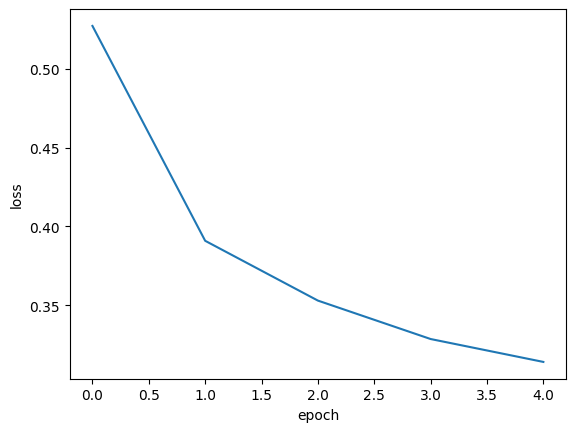

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

파이썬 리스트의 인겟스는 0부터 시작하므로 5개의 에포크가 0에서부터 4까지 x축에 표현된다. y축은 계산된 손실 값이다.

이번에는 정확도를 출력해보자.

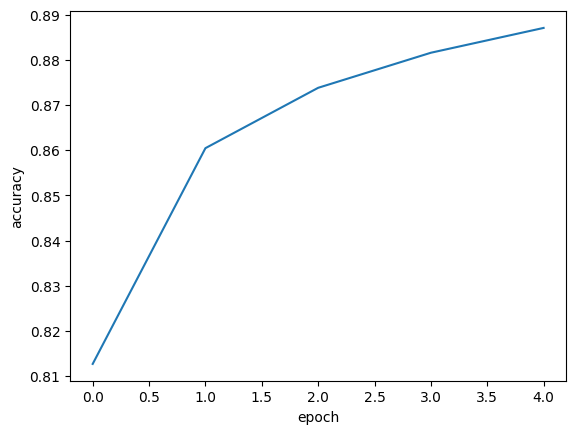

In [7]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

확실히 에포크마다 손실이 감소하고 정확도가 향상한다. 그렇다면 에포크를 늘려서 더 훈련해 봐하지 않을까? 계속 손실이 감소하니까?

그럼 이번에는 에포크 횟수를 20으로 늘려서 모델을 훈련하고 손실 그래프를 그려보자.

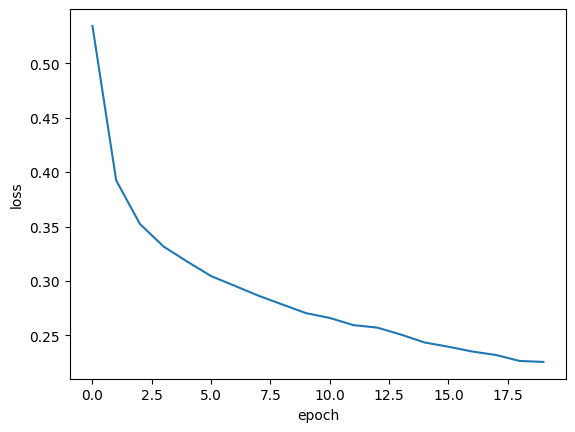

In [8]:
model = model_fn()
model.compile(loss ='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs = 20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

예상대로 손실이 잘 감소한다. 이전보다 더 나은 모델을 훈련한 것일까? 이전에 배웠던 것 중에 놓친 것이 있지 않은가?

### 검증 손실
4장에서 확률적 경사 하강법을 사용했을 때 과대/ 과소적합과 에포크 사이의 관계를 알아봤다. 인공 신경망은 모두 일종의 경사 하강법을 사용하기 때문에 동일한 개념이 여기에도 적용된다.

에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라 검증 세트에 대한 점수도 필요하다. 따라서 앞에서처럼 훈련 세트의 손실만 그려서는 안 된다. 4장에서는 정확도를 사용하여 과대/과소적합을 설명했지만 이 장에서는 손실을 사용하여 과대/과소적합을 다루자.

에포크마다 검증 손실을 게산하기 위해 케라스 모델의 fit() 메서드에 검증 데이터를 전달할 수 있다. 다음처럼 validation_data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달한다.

In [9]:
model = model_fn()
model.compile(loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data = (val_scaled, val_target))

반환된 history.history 딕셔너리에 어떤 값이 들어 있는지 키를 확인해보자.

In [10]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


검증 세트에 대한 손실은 'val_loss'에 들어 있고 정확도는 'val_accuracy'에 들어 있다. 과대/과소적합 문제를 조사하기 위해 훈련 손실과 검증 손실을 한 그래프에 그려서 비교해보자.

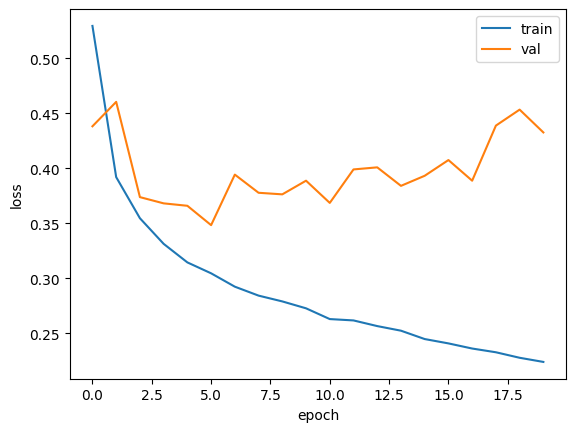

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

초기에 검증 손실이 감소하다가 다섯 번째 에포크 만에 다시 상승하기 시작한다.
훈련 손실은 꾸준히 감소하기 때문에 전형적인 과대적합 모델이 만들어진다. 검증 손실이 상승하는 시점을 한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것이다.

과대적합을 막기 위해 3장에서 배웠던 규제 방식 대신에 신경망에 특화된 규제 방법을 다음 섹션에서 다루어 보자. 당장은 옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완화시킬 수 있는지알아보자.

기본 RMSprop 옵티마이저는 많은 문제에서 잘 동작한다. 만약 이 옵티마이저 대신 다른 옵티마이절르 테스트해 본다면 Adam이 좋은 선택이다. Adam은 적응적 학습률을 사용하기 때문에 에포크가 진행되면서 학습률의 크기를 조정할 수 있다. Adam 옵티마이저를 적용해보고 훈련 손실과 검증 손실을 다시 그려보자.

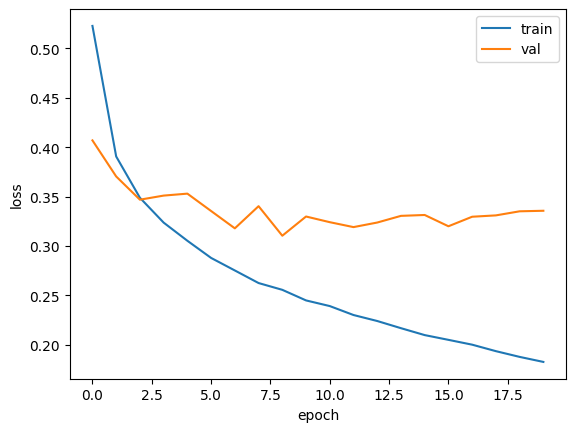

In [12]:
model = model_fn()
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data =(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대 적합이 훨씬 줄었다. 검증 손실 그래프에 여전히 요동이 남아 있지만 열 번째 에포크까지 전반적인 감소 추세가 이어지고 있다. 이는 Adam 옵티마이저가 이 데이터셋에 잘 맞는다는 것을 보여준다. 더 나은 손실 곡선을 얻으려면 학습률을 조정해서 다시 시도해 볼 수도 있다. 다음 섹션으로 이동해 신경망에서 사용하는 대표적인 규제 방법을 알아보자.

###드롭아웃

드롭아웃(dropout)은 딥러닝의 아버지로 불리는 제프리 힌턴이 소개했다. 이 방식은 다음 그림처럼 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(즉 뉴런의 출력을 0으로 만들어 과대적합을 막는다.)

어떤 샘플을 처리할 때는 은닉층의 두 번째 뉴런이 드롭아웃되어 h_2 출력이 없다. 다른 샘플을 처리할 때는 은닉층의 첫 번째 뉴런이 드롭아웃되어 h_1 출력이 없다. 뉴런은 랜덤하게 드롭아웃 되고 얼마나 많은 뉴런을 드롭할지는 우리가 정해야 할 또 다른 하이퍼파라미터이다.

드롭아웃이 왜 과대적합을 막을까? 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입렵게 대해 주의를 기울여야 한다. 일부 뉴런의 출력이 없을 수 있다는 것을 감안하면 이 신경망은 더 안정적인 예측을 만들 수 있을 것이다.

또 다른 해석은 드롭아웃을 적용해 훈련하는 것은 마치 2개의 신경망을 앙상블 하는 것 처럼 상상할 수 있다. 5장에서 보았듯이 앙상블은 과대적합을 막아 주는 아주 좋은 기법이다.

케라스에서는 드롭아웃을 keras.layers 패키지 아래 Dropout 클래스로 제공한다. 어떤 층의 뒤에 드롭아웃을 두어 이 층의 출력을 랜덤하게 0으로 만드느 것이다.드롭아웃이 층처럼 사용되지만 훈련되는 모델 파라미터는 없다.

그럼 앞서 정의한 model_fn() 함수에 드롭아웃 객체를 전달하여 층을 추가해보자.
여기에서는 30% 정도를 드롭아웃한다. 만들어진 모델의 summary() 메서드를 사용해 드롭아웃 층이 잘 추가되었는지 확인해보자.

In [13]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


출력 결과에서 볼 수 있듯이 은닉층 뒤에 추가된 드롭아웃 층(Dropout)은 훈련되는 모델 파라미터가 없다. 또한 입력과 출력의 크기가 같다. 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않는다.

물론 훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야한다. 훈련된 모든 뉴런을 사용해야 올바른 예측을 수행할 수 있다. 그렇다면 모델을 훈련한 다음 다시 빼야 할까? 아니다. 똑똑하게도 텐서플로와 케라스는 모델을 평가와 에측에 사용할 때는 자동으로 드롭아웃을 적용하지 않는다. 그래서 마음 편하게 검증 점수를 게산할 수 있다. 이전과 마찬가지로 훈련 손실과 검증 손실의 그래프를 그려 비교해보자.

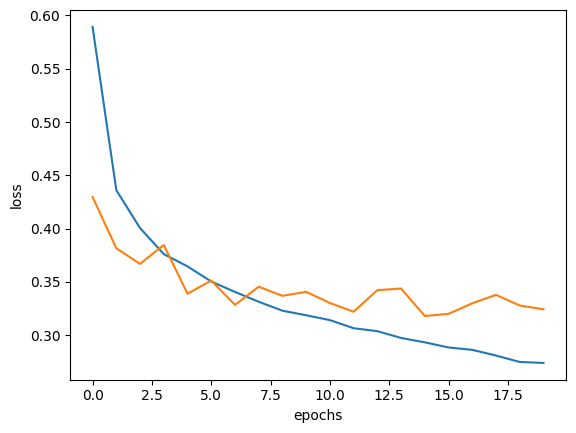

In [14]:
model.compile(optimizer ='adam', loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

과대적합이 확실히 줄었다. 열 번째 에포크 정도에서 검증 손실의 감소가 멈추지만 크게 상승하지 않고 어느 정도 유지되고 있다.

이 모델은 20번의 에포크 동안 훈련을 했기 때문에 결국 다소 과대적합 되어 있다. 그렇다면 과대적합 되지 않은 모델을 얻기 위해 에포크 횟수를 10으로 하고 다시 훈련하자.

###모델 저장과 복원

에포크 횟수를 10으로 다시 지정하고 모델을 훈련하자. 그리고 나중에 한빛 마켓의 패션 럭키백 런칭에 사용하려면 이 모델을 저장해야한다.

In [15]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')
history = model.fit(train_scaled, train_target, epochs = 10, verbose = 0,
                    validation_data =(val_scaled, val_target))

케라스 모델은 훈련된 모델의 파라미터를 저장하는 간편한 save_weights() 메서드를 제공한다. 기본적으로 이 베서드는 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.


In [16]:
model.save_weights('model-weights.h5')

또한 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공한다. 기본적으로 이 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

In [17]:
model.save('model-whole.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


간단하다. 이 두 파일이 잘 만들어졌는지 확인해 보자.

In [18]:
!ls -al *.h5

-rw-r--r-- 1 root root 333320 Mar 11 12:56 model-weights.h5
-rw-r--r-- 1 root root 981176 Mar 11 12:56 model-whole.h5


두 가지 실험을 해보자. 첫 번째는 훈련을 하지 않은 새로운 모델을 만들고 model_weights.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용한다. 두 번째는 아예 model-whole.h5 파일에서 새로운 모델을 만들어 바로 사용한다. 먼저 첫 번째 실험부터 시작하자.

In [19]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

훈련하지 않은 새로운 모델을 만들고 이전에 저장했던 모델 파라미터를 적재했다. 이때 사용하는 메서드는 save_weights()와 쌍을 이루는 load_weights() 메서드이다.

 * load_weights() 메서드를 사용하려면 save_weights() 메서드로 저장했던 모델과 정확히 같은 구조를 가져야 한다. 그렇지 않으면 에러가 발생한다. 여기에서는 model_fn()함수를 사용해 동일한 모델을 만들어 사용했다.

이 모델의 검증 정확도를 확인해보자. 케라스에서 예측을 수행하는 predict() 메서드는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환한다. 패션MNIST 데이터셋이 다중 분류 문제이기 때문이다. (이진 분류 문제라면 양성 클래스에 대한 확률 하나만 반환한다.)

패션 MNIST 데이터셋이서 덜어낸 검증 세트의 샘플 개수는 12,000개이기 때문에 predict() 메서드는 (12000,10)크기의 배열을 반환한다.

따라서 조금 번거롭지만 10개 확률 중에 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산해보자.

In [20]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis = -1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 2ms/step
0.8790833333333333


모델의 predict() 메서드 결과에서 가장 큰 값을 고르기 위해 넘파이 argmax() 함수를 사용했다. 이 함수는 배열에서 가장 큰 값의 인덱스를 반환한다. 예를 들어 배열의 첫 번째 원소가 가장 큰 값일 경우 0을 반환한다. 다행히 우리가 준비한 타깃값도 0부터 시작하기 때문에 비교하기 좋다.

argmax() 함수의 axis = -1은 배열의 마지막 차원을 따라 최댓값을 고른다. 검증 세트는 2차원 배열이기 때문에 마지막 차원은 1이 된다.

이번에는 모델 전체를 파일에서 읽은 다음 검증 세트의 정확도를 출력해보자. 모델이 저장된 파일을 읽을 때는 케라스가 제공하는 load_model() 함수를 사용한다.

In [21]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3332 - accuracy: 0.8791


[0.333191841840744, 0.8790833353996277]

같은 모델을 저장하고 다시 불러들였기 때문에 위와 동일한 정확도를 얻었다.

그런데 이 과정을 돌이켜 보면 20번의 에포크 동안 모델을 훈련하여 검증 점수가 상승하는 지점을 확인했다. 그다음 모델을 과대적합 되지 않는 에포크만큼 다시 훈련했다. 모델을 두 번씩 훈련하지 않고 한 번에 끝낼 수 는 없을까? 드디어 케라스의 콜백을 사용할 차례다.

###콜백

콜백(callback)은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들이다. fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용한다. 여기서 사용할 ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장한다. save_best_only = True 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다. 저장될 파일 이름을 'best-model.h5'로 지정하여 콜백을 적용해보자.

In [22]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy',
              metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                               save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data = (val_scaled, val_target),
          callbacks = [checkpoint_cb])

model_fn() 함수로 모델을 만들고 compile() 메서드를 호출하는 것은 이전과 동일하다. ModelCheckpoint 클래스의 객체 checkpoint_cb를 만든 후 fit() 메서드의 callbacks 매개변수에 리스트로 감싸서 전달한다. 모델이 훈련한 후에 best-model.h5에 최상의 검증 점수를 낸 모델이 저장된다. 이 모델을 load_model() 함수로 다시 읽어서 예측을 수행해보자.

In [23]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3181 - accuracy: 0.8840


[0.318094938993454, 0.8840000033378601]

훨씬 편하다. ModelCheckpoint 콜백이 가장 낮은 검증 점수의 모델을 자동으로 저장해 주었다. 하지만 여전히 20번의 에포크 동안 훈련을 한다. 사실 검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없다. 이때 훈련을 중지하면 컴퓨터 자원가 시간을 아낄 수 있다. 이렇게 과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 조기 종료(early stopping)이라고 부르며, 딥러닝 분야에서 널리 사용된다.

조기 종료는 훈련 에포크 횟수를 제한하는 역할이지만 모델이 과대적합되는 것을 막아 주기 때문에 규제 방법 중 하나로 생각할 수도 있다.

케라스에는 조기 종료를 위한 EarlyStopping 콜백을 제공한다. 이 콜백의 patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 지정한다. 예를 들어 다음 코드에서처럼 patience = 2로 지정하면 2번 연속 검증 점수가 향상되지 않으면 훈련을 중지한다. 또한 restore_best_weight 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.

EarlyStopping 콜백을  ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다. 또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.

이 두 콜백을 함께 사용해보자.

In [24]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose = 0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


EarlyStopping 콜백을 추가한 것 외에는 이전과 동일하다. fit() 메서드의 callbacks 매개변수에 2개의 콜백을 리스트로 전달한 것을 눈여겨보자. 훈련을 마치고 나면 몇 번째 에 포크에서 훈련이 중지되었는지 early_stopping_cb 객체의 stopped_epoch 속성에서 확인할 수 있다.

In [25]:
print(early_stopping_cb.stopped_epoch)

10


결과는 에포크 횟수가 0부터 시작하기 때문에 10은 열한 번째 에포크에서 훈련이 중지되었다는 것을 의미한다. patience를 2로 지정했으므로 최상의 모델은 여 번째 일것이다.

훈련 손실과 검증 손실을 출력해서 확인해보자.

<ipython-input-26-dc16c285ff11>:5: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(['train'],['val'])


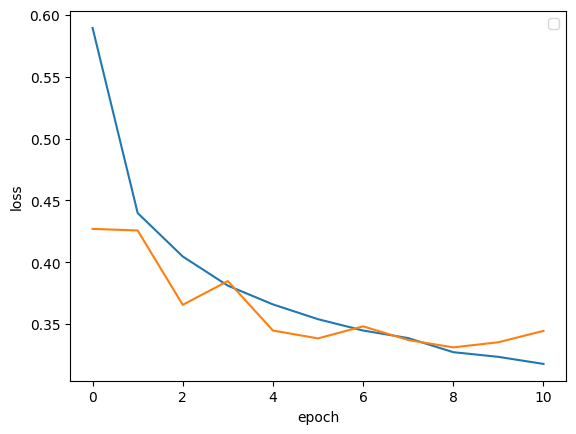

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train'],['val'])
plt.show()

여덟 번째 에포크에서 가장 낮은 손실을 기록했고 열 번째 에포크에서 훈련이 중지 되었다. 조기 종료 기법을 사용하면 안심하고 에포크 횟수를 크게 지정해도 괜찮습니다. 컴퓨터 자원과 시간을 아낄 수 있고 ModelCheckpoint 콜백과 함께 사용하면 최상의 모델을 자동으로 저장해 주므로 편한다.
마지막으로 조기 종료로 얻은 사용해 검증 세트에 대한 성능을 확인해보자.

In [27]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 6ms/step - loss: 0.3313 - accuracy: 0.8775


[0.33127346634864807, 0.8774999976158142]